# Import

In [1]:
import numpy as np
from pdg_const import pdg
import matplotlib
import matplotlib.pyplot as plt
import pickle as pkl
import sys
import time
from helperfunctions import display_time, prepare_plot
import cmath as c
import scipy.integrate as integrate
from scipy.optimize import fminbound
from array import array as arr
import collections
from itertools import compress
import tensorflow as tf
import zfit
from zfit import ztf

c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\util\execution.py:53: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Build model and graphs
## Create graphs

In [2]:
def formfactor( q2, subscript): #returns real value
    #check if subscript is viable

    if subscript != "0" and subscript != "+" and subscript != "T":
        raise ValueError('Wrong subscript entered, choose either 0, + or T')

    #get constants

    mK = ztf.constant(pdg['Ks_M'])
    mbstar0 = ztf.constant(pdg["mbstar0"])
    mbstar = ztf.constant(pdg["mbstar"])
    b0 = ztf.constant(pdg["b0"])
    bplus = ztf.constant(pdg["bplus"])
    bT = ztf.constant(pdg["bT"])

    mmu = ztf.constant(pdg['muon_M'])
    mb = ztf.constant(pdg['bquark_M'])
    ms = ztf.constant(pdg['squark_M'])
    mB = ztf.constant(pdg['Bplus_M'])

    #N comes from derivation in paper

    N = 3

    #some helperfunctions

    tpos = (mB - mK)**2
    tzero = (mB + mK)*(ztf.sqrt(mB)-ztf.sqrt(mK))**2

    z_oben = ztf.sqrt(tpos - q2) - ztf.sqrt(tpos - tzero)
    z_unten = ztf.sqrt(tpos - q2) + ztf.sqrt(tpos - tzero)
    z = tf.divide(z_oben, z_unten)

    #calculate f0

    if subscript == "0":
        prefactor = 1/(1 - q2/(mbstar0**2))
        _sum = 0

        for i in range(N):
            _sum += b0[i]*(tf.pow(z,i))

        return tf.complex(prefactor * _sum, ztf.constant(0.0))

    #calculate f+ or fT

    else:
        prefactor = 1/(1 - q2/(mbstar**2))
        _sum = 0

        if subscript == "T":
            b = bT
        else:
            b = bplus

        for i in range(N):
            _sum += b[i] * (tf.pow(z, i) - ((-1)**(i-N)) * (i/N) * tf.pow(z, N))

        return tf.complex(prefactor * _sum, ztf.constant(0.0))

def resonance(q, _mass, width, phase, scale):

    q2 = tf.pow(q, 2)

    mmu = ztf.constant(pdg['muon_M'])

    p = 0.5 * ztf.sqrt(q2 - 4*(mmu**2))

    p0 =  0.5 * ztf.sqrt(_mass**2 - 4*mmu**2)

    gamma_j = tf.divide(p, q2) * _mass * width / p0

    #Calculate the resonance

    _top = tf.complex(_mass * width, ztf.constant(0.0))

    _bottom = tf.complex(_mass**2 - q2, -_mass*gamma_j)

    com = _top/_bottom

    #Rotate by the phase

    r = tf.abs(com)

    _phase = tf.angle(com)

    _phase += phase

    x = tf.cos(phase)*r
    y = tf.sin(phase)*r

    com = tf.complex(scale* x, scale * y)

    return com

def bifur_gauss(q, mean, sigma_L, sigma_R, scale):

    _exp = tf.where(q < mean, ztf.exp(- tf.pow((q-mean),2) / (2 * sigma_L**2)), ztf.exp(- tf.pow((q-mean),2) / (2 * sigma_R**2)))

    #Scale so the total area under curve is 1 and the top of the cusp is continuous

    dgamma = scale*_exp/(ztf.sqrt(2*np.pi))*2*(sigma_L*sigma_R)/(sigma_L+sigma_R)

    com = ztf.complex(dgamma, ztf.constant(0.0))

    return com

def axiv_nonres(q):

    GF = ztf.constant(pdg['GF'])
    alpha_ew = ztf.constant(pdg['alpha_ew'])
    Vtb = ztf.constant(pdg['Vtb'])
    Vts = ztf.constant(pdg['Vts'])
    C10eff = ztf.constant(pdg['C10eff'])

    mmu = ztf.constant(pdg['muon_M'])
    mb = ztf.constant(pdg['bquark_M'])
    ms = ztf.constant(pdg['squark_M'])
    mK = ztf.constant(pdg['Ks_M'])
    mB = ztf.constant(pdg['Bplus_M'])

    q2 = tf.pow(q, 2)

    #Some helperfunctions

    beta = ztf.sqrt(tf.abs(1. - 4. * mmu**2. / q2))

    kabs = ztf.sqrt(mB**2. +tf.pow(q2, 2)/mB**2. + mK**4./mB**2. - 2. * (mB**2. * mK**2. + mK**2. * q2 + mB**2. * q2) / mB**2.)

    #prefactor in front of whole bracket

    prefactor1 = GF**2. *alpha_ew**2. * (tf.abs(Vtb*Vts))**2. * kabs * beta / (128. * np.pi**5.)

    #left term in bracket

    bracket_left = 2./3. * kabs**2. * beta**2. *tf.abs(tf.complex(C10eff, ztf.constant(0.0))*formfactor(q2, "+"))**2.

    #middle term in bracket

    _top = 4. * mmu**2. * (mB**2. - mK**2.) * (mB**2. - mK**2.)

    _under = q2 * mB**2.

    bracket_middle = _top/_under *tf.pow(tf.abs(tf.complex(C10eff, ztf.constant(0.0)) * formfactor(q2, "0")), 2)

    #Note sqrt(q2) comes from derivation as we use q2 and plot q

    return prefactor1 * (bracket_left + bracket_middle) * 2 *ztf.sqrt(q2)

def vec(q, funcs):
    
    q2 = tf.pow(q, 2)

    GF = ztf.constant(pdg['GF'])
    alpha_ew = ztf.constant(pdg['alpha_ew'])
    Vtb = ztf.constant(pdg['Vtb'])
    Vts = ztf.constant(pdg['Vts'])
    C7eff = ztf.constant(pdg['C7eff'])

    mmu = ztf.constant(pdg['muon_M'])
    mb = ztf.constant(pdg['bquark_M'])
    ms = ztf.constant(pdg['squark_M'])
    mK = ztf.constant(pdg['Ks_M'])
    mB = ztf.constant(pdg['Bplus_M'])

    #Some helperfunctions

    beta = ztf.sqrt(tf.abs(1. - 4. * mmu**2. / q2))

    kabs = ztf.sqrt(mB**2. + tf.pow(q2, 2)/mB**2. + mK**4./mB**2. - 2 * (mB**2 * mK**2 + mK**2 * q2 + mB**2 * q2) / mB**2)

    #prefactor in front of whole bracket

    prefactor1 = GF**2. *alpha_ew**2. * (tf.abs(Vtb*Vts))**2 * kabs * beta / (128. * np.pi**5.)

    #right term in bracket

    prefactor2 = kabs**2 * (1. - 1./3. * beta**2)

    abs_bracket = tf.abs(c9eff(q, funcs) * formfactor(q2, "+") + tf.complex(2.0 * C7eff * (mb + ms)/(mB + mK), ztf.constant(0.0)) * formfactor(q2, "T"))**2

    bracket_right = prefactor2 * abs_bracket

    #Note sqrt(q2) comes from derivation as we use q2 and plot q

    return prefactor1 * bracket_right * 2 * ztf.sqrt(q2)

def c9eff(q, funcs):

    C9eff_nr = tf.complex(ztf.constant(pdg['C9eff']), ztf.constant(0.0))

    c9 = C9eff_nr

    c9 = c9 + funcs

    return c9

## Build pdf

In [3]:
class total_pdf(zfit.pdf.ZPDF):
    _N_OBS = 1  # dimension, can be omitted
    _PARAMS = ['jpsi_mass', 'jpsi_scale', 'jpsi_phase', 'jpsi_width',
                'psi2s_mass', 'psi2s_scale', 'psi2s_phase', 'psi2s_width',
                'cusp_mass', 'sigma_L', 'sigma_R', 'cusp_scale'
                ]  # the name of the parameters

    def _unnormalized_pdf(self, x):

        def jpsi_res(q):
            return resonance(q, _mass = self.params['jpsi_mass'], scale = self.params['jpsi_scale'], phase = self.params['jpsi_phase'], width = self.params['jpsi_width'])

        def psi2s_res(q):
            return resonance(q, _mass = self.params['psi2s_mass'], scale = self.params['psi2s_scale'], phase = self.params['psi2s_phase'], width = self.params['psi2s_width'])

        def cusp(q):
            return bifur_gauss(q, mean = self.params['cusp_mass'], sigma_L = self.params['sigma_L'], sigma_R = self.params['sigma_R'], scale = self.params['cusp_scale'])

        funcs = jpsi_res(x) + psi2s_res(x) + cusp(x)

        vec_f = vec(x, funcs)

        axiv_nr = axiv_nonres(x)

        tot = vec_f + axiv_nr

        return tot

## Load data

In [4]:
x_min = 2*pdg['muon_M']
x_max = (pdg["Bplus_M"]-pdg["Ks_M"]-0.1)

obs = zfit.Space('q', limits = (x_min, x_max))

with open(r"./data/slim_points/slim_points_toy_0_range({0}-{1}).pkl".format(int(x_min), int(x_max)), "rb") as input_file:
    part_set = pkl.load(input_file)

x_part = part_set['x_part']

x_part = x_part.astype('float64')

data = zfit.data.Data.from_numpy(array=x_part, obs=obs)

## Setup parameters

In [5]:
#jpsi

jpsi_mass, jpsi_width, jpsi_phase, jpsi_scale = pdg["jpsi"]

jpsi_m = zfit.Parameter("jpsi_m", ztf.constant(jpsi_mass), floating = False)
jpsi_w = zfit.Parameter("jpsi_w", ztf.constant(jpsi_width), floating = False)
jpsi_p = zfit.Parameter("jpsi_p", ztf.constant(jpsi_phase), floating = False)
jpsi_s = zfit.Parameter("jpsi_s", ztf.constant(jpsi_scale), floating = False)

#psi2s

psi2s_mass, psi2s_width, psi2s_phase, psi2s_scale = pdg["psi2s"]

psi2s_m = zfit.Parameter("psi2s_m", ztf.constant(psi2s_mass), floating = False)
psi2s_w = zfit.Parameter("psi2s_w", ztf.constant(psi2s_width), floating = False)
psi2s_p = zfit.Parameter("psi2s_p", ztf.constant(psi2s_phase), floating = False)
psi2s_s = zfit.Parameter("psi2s_s", ztf.constant(psi2s_scale), floating = False)

#cusp

cusp_mass, sigma_R, sigma_L, cusp_scale = 3550, 3e-7, 200, 7

cusp_m = zfit.Parameter("cusp_m", ztf.constant(cusp_mass))
sig_L = zfit.Parameter("sig_L", ztf.constant(sigma_L))
sig_R = zfit.Parameter("sig_R", ztf.constant(sigma_R))
cusp_s = zfit.Parameter("cusp_s", ztf.constant(cusp_scale))

Instructions for updating:
Colocations handled automatically by placer.


## Test if graphs actually work and compute values

In [6]:
def total_test_tf(xq):

    def jpsi_res(q):
        return resonance(q, jpsi_m, jpsi_s, jpsi_p, jpsi_w)

    def psi2s_res(q):
        return resonance(q, psi2s_m, psi2s_s, psi2s_p, psi2s_w)

    def cusp(q):
        return bifur_gauss(q, cusp_m, sig_L, sig_R, cusp_s)

    funcs = jpsi_res(xq) + psi2s_res(xq)# + cusp(xq)

    vec_f = vec(xq, funcs)

    axiv_nr = axiv_nonres(xq)

    tot = vec_f + axiv_nr
    
    return tot

calcs = zfit.run(total_test_tf(x_part))

test_q = np.linspace(x_min, x_max, 1000000)

calcs_test = zfit.run(total_test_tf(test_q))

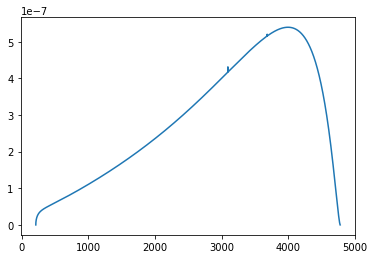

In [7]:
# plt.plot(x_part, calcs, '.')
plt.plot(test_q, calcs_test)
# plt.ylim(0, 0.0000007)
# plt.xlim(3000, 3750)
plt.savefig('test.png')

## Setup pdf

In [8]:
total_f = total_pdf(obs=obs, jpsi_mass = jpsi_m, jpsi_scale = jpsi_s, jpsi_phase = jpsi_p, jpsi_width = jpsi_w,
            psi2s_mass = psi2s_m, psi2s_scale = psi2s_s, psi2s_phase = psi2s_p, psi2s_width = psi2s_w,
            cusp_mass = cusp_m, sigma_L = sig_L, sigma_R = sig_R, cusp_scale = cusp_s)

# print(total_pdf.obs)

# Sampling
## One sample

In [14]:
nevents = 1000

total_f.sample(n=nevents)

ResourceExhaustedError: OOM when allocating tensor with shape[380152,380152] and type bool on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node ZPDF_5/sample/while/Greater_1 (defined at c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\sample.py:154) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'ZPDF_5/sample/while/Greater_1', defined at:
  File "c:\users\sa_li\.conda\envs\rmd\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\sa_li\.conda\envs\rmd\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "c:\users\sa_li\.conda\envs\rmd\lib\asyncio\base_events.py", line 539, in run_forever
    self._run_once()
  File "c:\users\sa_li\.conda\envs\rmd\lib\asyncio\base_events.py", line 1775, in _run_once
    handle._run()
  File "c:\users\sa_li\.conda\envs\rmd\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tornado\gen.py", line 781, in inner
    self.run()
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tornado\gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\IPython\core\interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\IPython\core\interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\IPython\core\interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\IPython\core\interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-8af5da1d0911>", line 3, in <module>
    total_f.sample(n=nevents)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\basemodel.py", line 871, in sample
    sample = self._single_hook_sample(n=n, limits=limits, name=name)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\basemodel.py", line 877, in _single_hook_sample
    return self._hook_sample(n=n, limits=limits, name=name)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\basepdf.py", line 489, in _hook_sample
    samples = super()._hook_sample(limits=limits, n=n, name=name)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\basemodel.py", line 880, in _hook_sample
    return self._norm_sample(n=n, limits=limits, name=name)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\basemodel.py", line 884, in _norm_sample
    return self._limits_sample(n=n, limits=limits, name=name)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\basemodel.py", line 887, in _limits_sample
    return self._call_sample(n=n, limits=limits, name=name)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\basemodel.py", line 901, in _call_sample
    return self._fallback_sample(n=n, limits=limits)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\basemodel.py", line 934, in _fallback_sample
    sample_and_weights_factory=self._sample_and_weights)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\sample.py", line 174, in accept_reject_sample
    back_prop=False)[1]  # backprop not needed here
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 3556, in while_loop
    return_same_structure)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 3087, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 3022, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\sample.py", line 154, in sample_body
    take_or_not = probabilities > random_thresholds
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 3922, in greater
    "Greater", x=x, y=y, name=name)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[380152,380152] and type bool on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node ZPDF_5/sample/while/Greater_1 (defined at c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\sample.py:154) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



## Toys

In [13]:
sampler = total_f.create_sampler(n=nevents)
nll = zfit.loss.UnbinnedNLL(model=total_f, data=sampler, fit_range = (x_min, x_max))

# for param in pdf.get_dependents():
#     param.set_value(initial_value)

sampler.resample(n=nevents)

# Randomise initial values
# for param in pdf.get_dependents():
#     param.set_value(random value here)

# Minimise the NLL
minimizer = zfit.minimize.MinuitMinimizer()
minimum = minimizer.minimize(nll)

ResourceExhaustedError: OOM when allocating tensor with shape[500000,500000] and type bool on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node ZPDF_4/create_sampler/while/Greater_1 (defined at c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\sample.py:154) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'ZPDF_4/create_sampler/while/Greater_1', defined at:
  File "c:\users\sa_li\.conda\envs\rmd\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\sa_li\.conda\envs\rmd\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "c:\users\sa_li\.conda\envs\rmd\lib\asyncio\base_events.py", line 539, in run_forever
    self._run_once()
  File "c:\users\sa_li\.conda\envs\rmd\lib\asyncio\base_events.py", line 1775, in _run_once
    handle._run()
  File "c:\users\sa_li\.conda\envs\rmd\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tornado\gen.py", line 781, in inner
    self.run()
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tornado\gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\IPython\core\interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\IPython\core\interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\IPython\core\interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\IPython\core\interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-bb295d251023>", line 1, in <module>
    sampler = total_f.create_sampler(n=nevents)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\basemodel.py", line 814, in create_sampler
    limits=limits, n=n, name=name)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\basemodel.py", line 835, in _create_sampler_tensor
    sample = self._single_hook_sample(n=n, limits=limits, name=name)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\basemodel.py", line 877, in _single_hook_sample
    return self._hook_sample(n=n, limits=limits, name=name)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\basepdf.py", line 489, in _hook_sample
    samples = super()._hook_sample(limits=limits, n=n, name=name)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\basemodel.py", line 880, in _hook_sample
    return self._norm_sample(n=n, limits=limits, name=name)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\basemodel.py", line 884, in _norm_sample
    return self._limits_sample(n=n, limits=limits, name=name)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\basemodel.py", line 887, in _limits_sample
    return self._call_sample(n=n, limits=limits, name=name)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\basemodel.py", line 901, in _call_sample
    return self._fallback_sample(n=n, limits=limits)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\basemodel.py", line 934, in _fallback_sample
    sample_and_weights_factory=self._sample_and_weights)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\sample.py", line 174, in accept_reject_sample
    back_prop=False)[1]  # backprop not needed here
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 3556, in while_loop
    return_same_structure)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 3087, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 3022, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\sample.py", line 154, in sample_body
    take_or_not = probabilities > random_thresholds
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 3922, in greater
    "Greater", x=x, y=y, name=name)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "c:\users\sa_li\.conda\envs\rmd\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[500000,500000] and type bool on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node ZPDF_4/create_sampler/while/Greater_1 (defined at c:\users\sa_li\.conda\envs\rmd\lib\site-packages\zfit\core\sample.py:154) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



# Fitting

In [ ]:
nll = zfit.loss.UnbinnedNLL(model=total_f, data=data, fit_range = (x_min, x_max))

minimizer = zfit.minimize.MinuitMinimizer()
# minimizer._use_tfgrad = False
result = minimizer.minimize(nll)

param_errors = result.error()

for var, errors in param_errors.items():
    print('{}: ^{{+{}}}_{{{}}}'.format(var.name, errors['upper'], errors['lower']))

print("Function minimum:", result.fmin)